In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import seaborn as sns

from compare_wandb import get_sweep_df, get_test_pdbs, load_attention_msa_results, add_apc_default

name_to_sweep_id = {
     'fatt-refactor-weird': 'mjsb2q9t',
     'fatt-refactor': 'e3sgcbzz',
}

In [2]:
def load_metatest():
    sweep_ids_to_name = {v: k for k, v in name_to_sweep_id.items()}
    pdb_id_map = get_test_pdbs()
    sweep_dfs = {
        sweep_name: get_sweep_df(
            sweep_id, sweep_name, sweep_name, pdb_id_map,
        ) for sweep_id, sweep_name in sweep_ids_to_name.items()
    }
    
    sweep_dfs = {k: s[s.run_state == "finished"] for k, s in sweep_dfs.items()}
    return sweep_dfs

In [3]:
old_model_df_dict = load_attention_msa_results()
df_dict = load_metatest()

100%|██████████| 748/748 [00:00<00:00, 56414.79it/s]

9ppr5f9y has 748 runs



100%|██████████| 748/748 [00:00<00:00, 55560.58it/s]

wqzai5ya has 748 runs



100%|██████████| 748/748 [00:00<00:00, 49540.33it/s]

zd8rc6j7 has 748 runs



100%|██████████| 748/748 [00:00<00:00, 65154.91it/s]

l37wrnsa has 748 runs



100%|██████████| 748/748 [00:00<00:00, 45743.15it/s]

mjsb2q9t has 748 runs



100%|██████████| 748/748 [00:00<00:00, 48215.58it/s]

e3sgcbzz has 748 runs


In [4]:
for key, value in old_model_df_dict.items():
        value["sweep_name"] = key
        old_model_df_dict[key] = value

for key, value in df_dict.items():
    value = value.drop(columns=["model"])
    value["model"] = key
    df_dict[key] = value

In [5]:
def parse_old_model(df):
    d = df[["sweep_name", "pdb", "pdb_idx", "num_seqs", "run_state", "Train_Precision_@_l/1", "Train_Precision_apc_@_l/1", "Train_Precision_@_l/5", "Train_Precision_apc_@_l/5", "Train_Auc", "Train_Auc_apc"]]
    d = d.rename(columns={
        "Train_Precision_@_l/1": "pr_at_L", 
        "Train_Precision_apc_@_l/1": "pr_at_L_apc", 
        "Train_Precision_@_l/5": "pr_at_L_5",
        "Train_Precision_apc_@_l/5": "pr_at_L_5_apc",
        "Train_Auc": "auc", 
        "Train_Auc_apc": "auc_apc"})
    d["log_num_seqs"] = np.log(d.num_seqs)
    return d

def parse_new_model(df):
    d = df[["sweep_name", "pdb", "pdb_idx", "num_seqs", "run_state", "pr_at_L", "pr_at_L_apc", "pr_at_L_5", "pr_at_L_5_apc", "auc", "auc_apc"]].copy()
    d["log_num_seqs"] = np.log(d.num_seqs)
    return d

parsed_old_df = {
    k: parse_old_model(v) for k, v in old_model_df_dict.items()
}

parsed_df = {
    k: parse_new_model(v) for k, v in df_dict.items()
}

In [6]:
assert len(set(parsed_old_df.keys()).intersection(set(parsed_df.keys()))) == 0, "Should not have key collisions!!"

concat_df = {**parsed_old_df, **parsed_df}
df = pd.concat(list(concat_df.values()))
print(df.shape)
non_null_idx = np.where(df.notnull().all(1))[0]
#print(f"Dropping {np.sum(~non_null_idx)} entries.")
df = df.iloc[non_null_idx]
print(df.shape)

(4313, 12)
(4312, 12)


In [7]:
for key in ["gremlin", "fatt-refactor", "old-fatt", "fatt-refactor-weird"]:
    df = add_apc_default(df, key)

/home/nickbhat/projects/mogwai/venv/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/nickbhat/projects/mogwai/venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


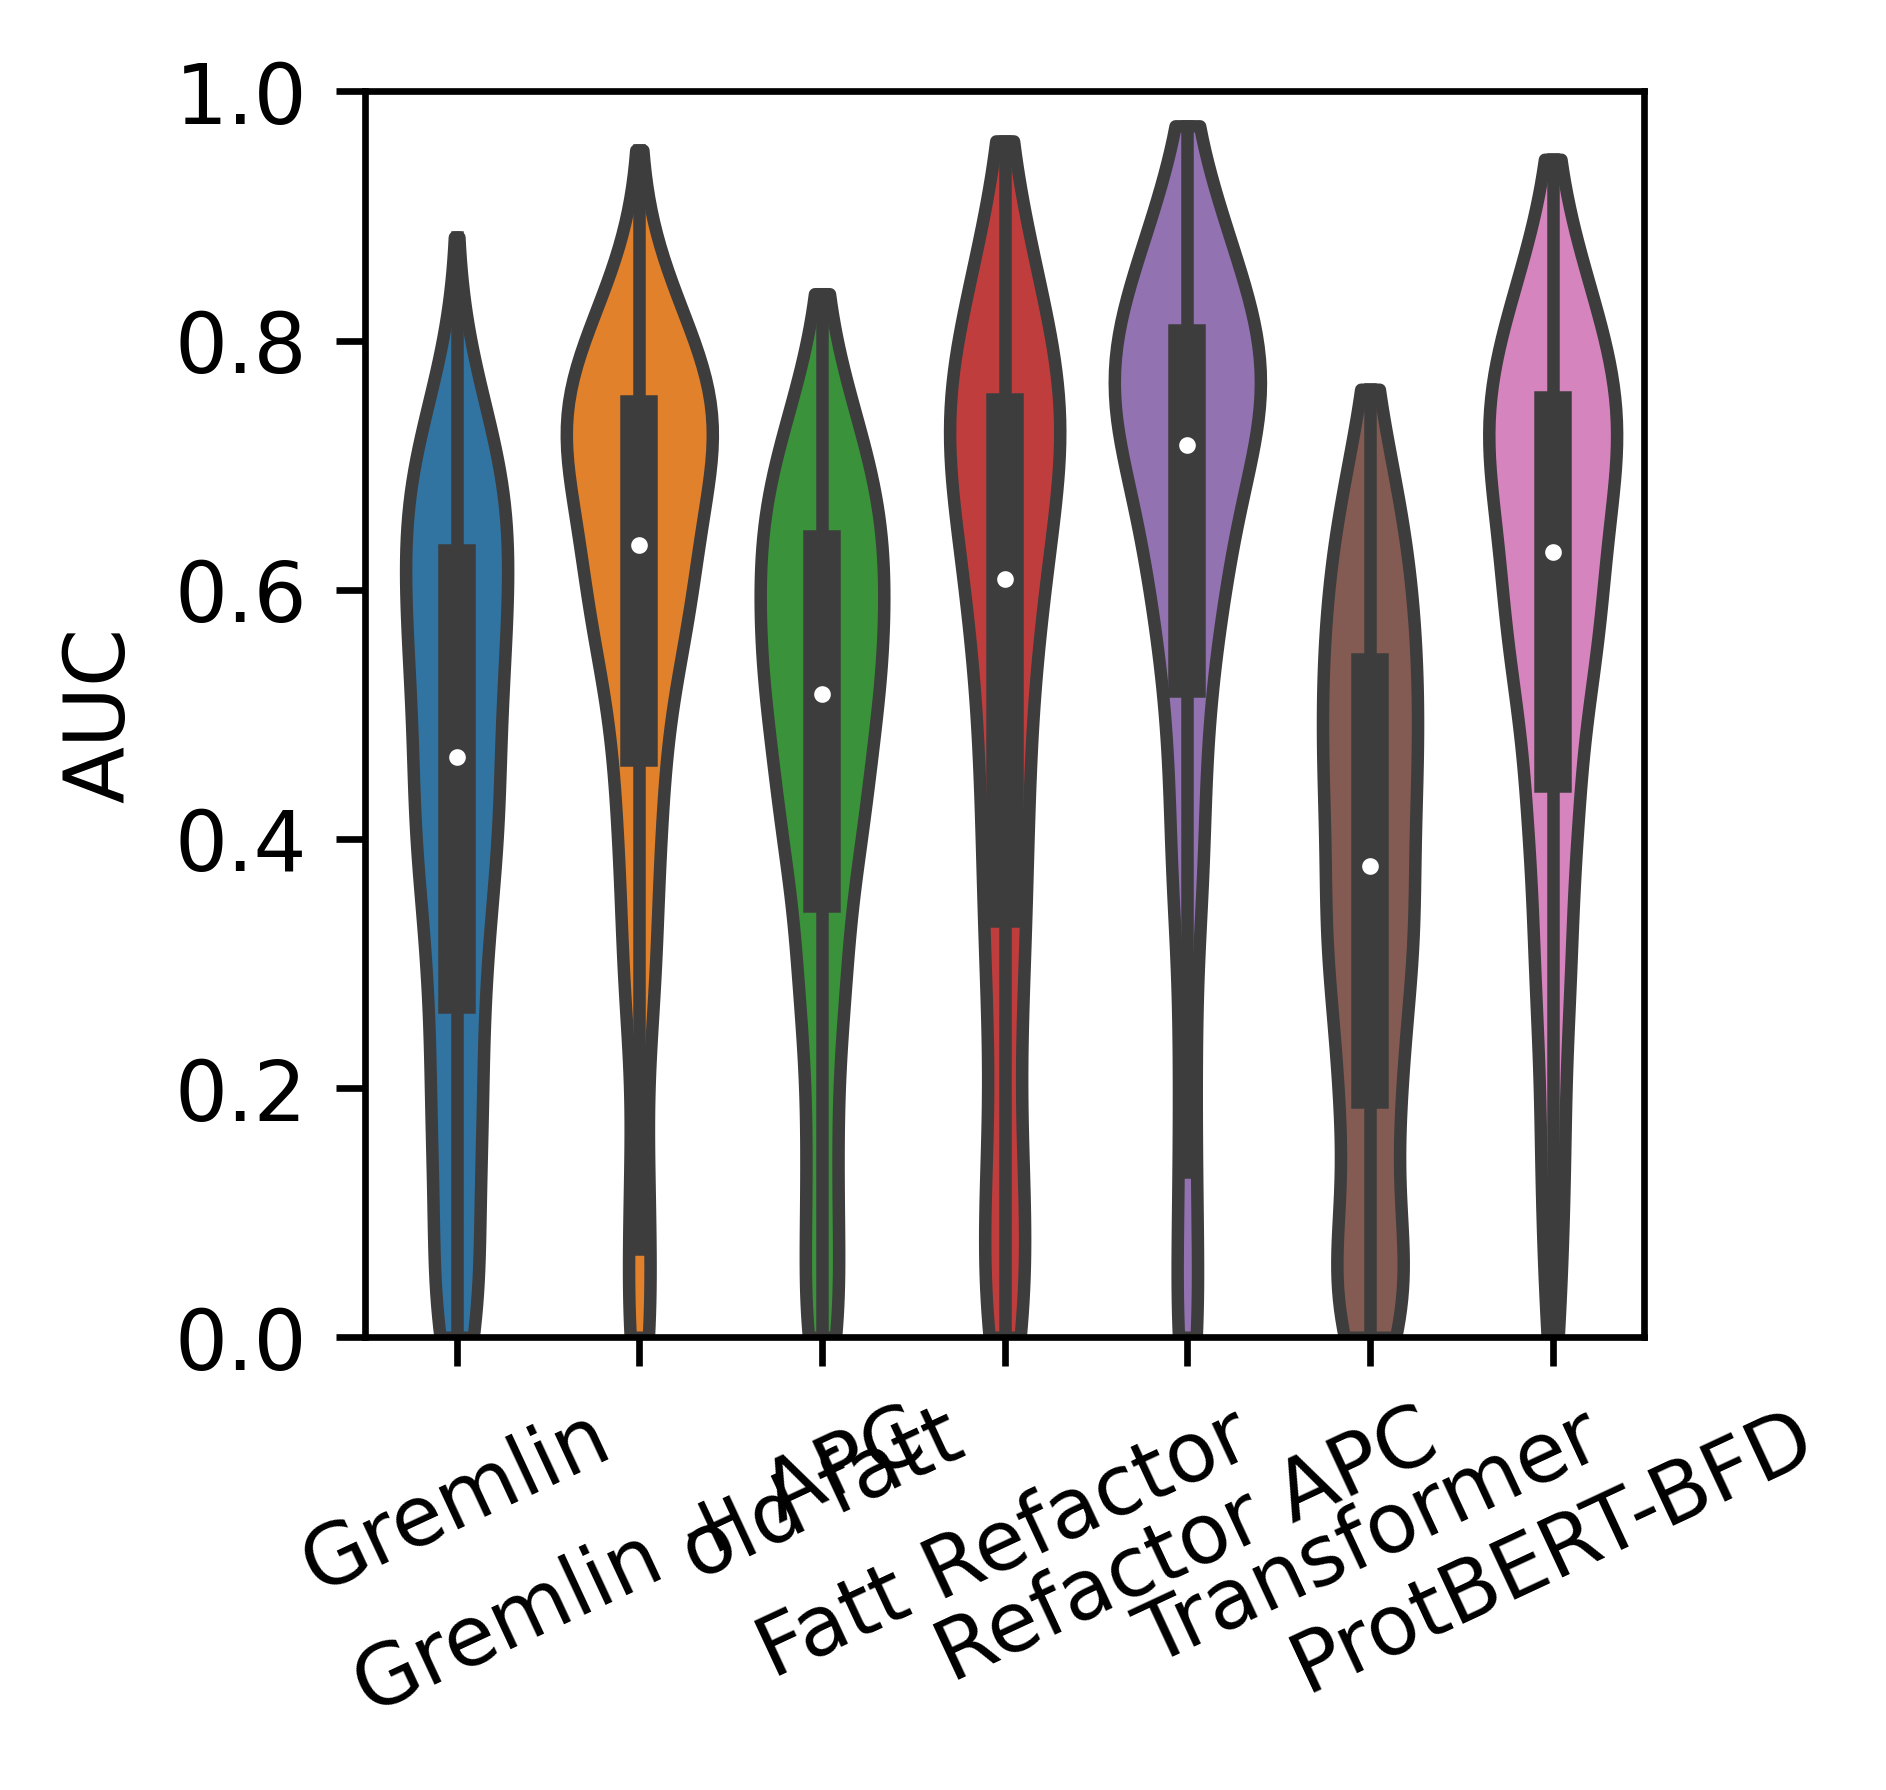

In [8]:
fig, ax = plt.subplots(figsize=(2.75,2.75), dpi=600)
sns.violinplot(x="sweep_name", y="auc", order=["gremlin", "gremlin-apc", "old-fatt", "fatt-refactor", "fatt-refactor-apc", "transformer", "protbert-bfd"], data=df, cut=0)
ax.set_xticklabels(["Gremlin", "Gremlin + APC", "old fatt", "Fatt Refactor", "Refactor APC", "Transformer", "ProtBERT-BFD"])
plt.xticks(rotation=25)
plt.xlabel("")
plt.ylabel("AUC")
plt.ylim(0, 1.0)
plt.savefig("oh_god.png", bbox_inches="tight", pad_inches=0.1)

(0.0, 1.0)

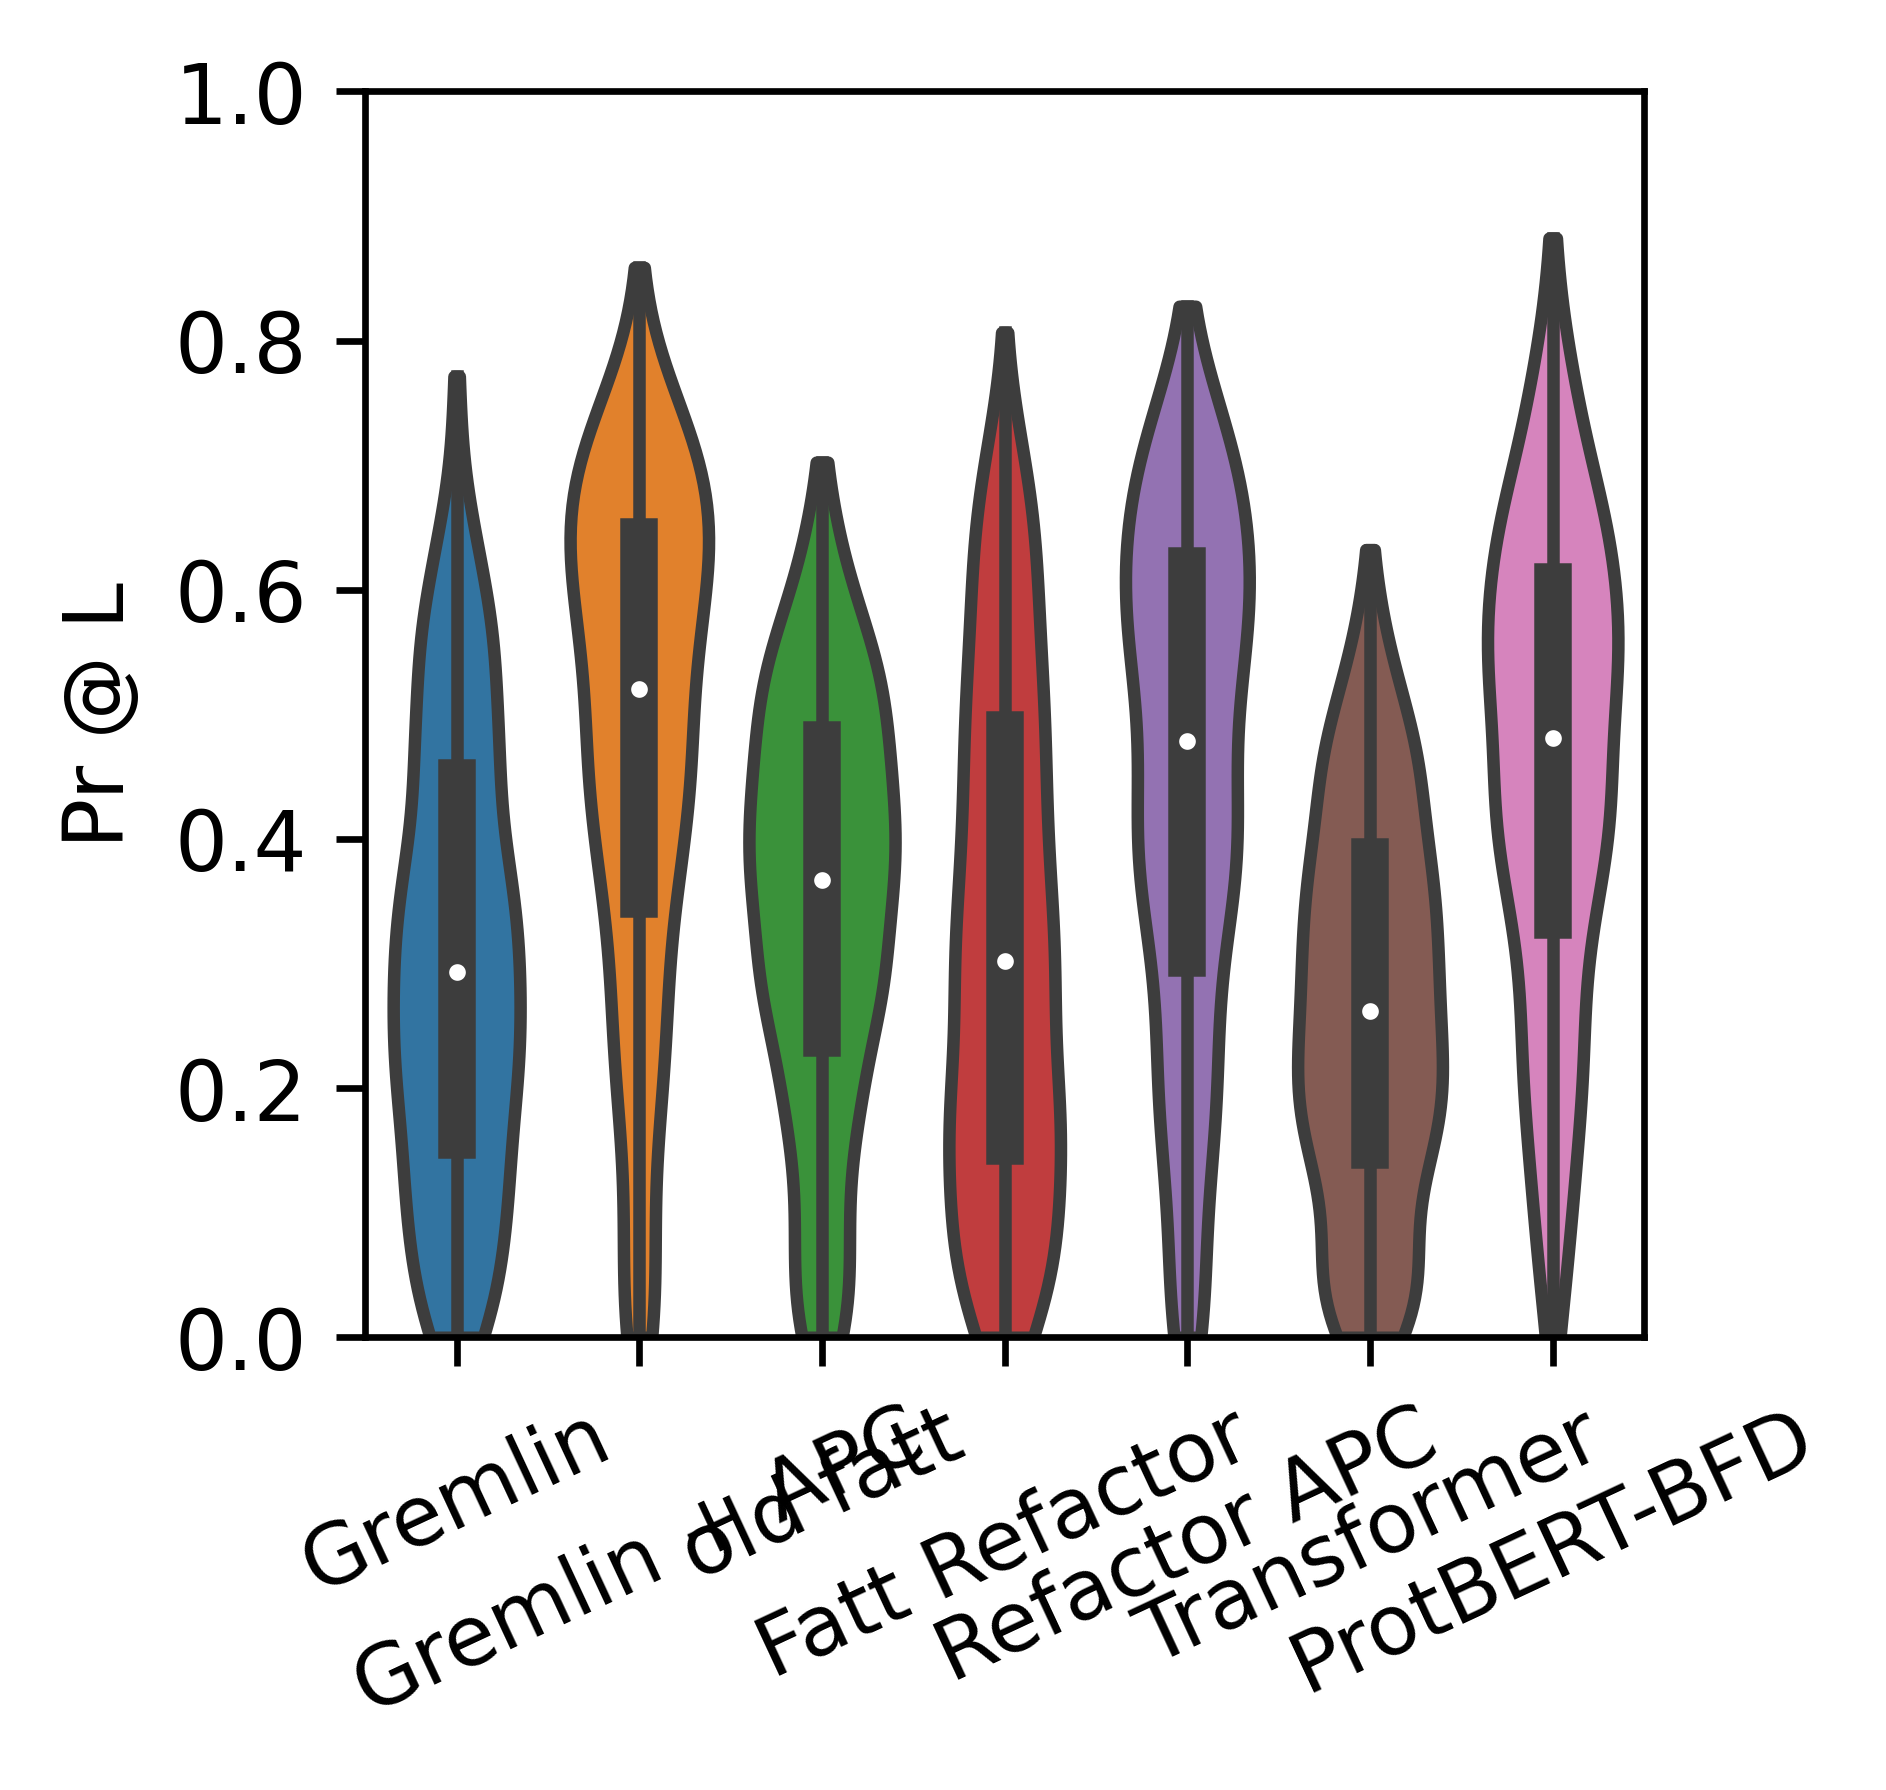

In [9]:
fig, ax = plt.subplots(figsize=(2.75,2.75), dpi=600)
sns.violinplot(x="sweep_name", y="pr_at_L", order=["gremlin", "gremlin-apc", "old-fatt", "fatt-refactor", "fatt-refactor-apc", "transformer", "protbert-bfd"], data=df, cut=0)
ax.set_xticklabels(["Gremlin", "Gremlin + APC", "old fatt", "Fatt Refactor", "Refactor APC", "Transformer", "ProtBERT-BFD"])
plt.xticks(rotation=25)
plt.xlabel("")
plt.ylabel("Pr @ L")
plt.ylim(0, 1.0)
#plt.savefig("oh_god.png", bbox_inches="tight", pad_inches=0.1)

/home/nickbhat/projects/mogwai/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """


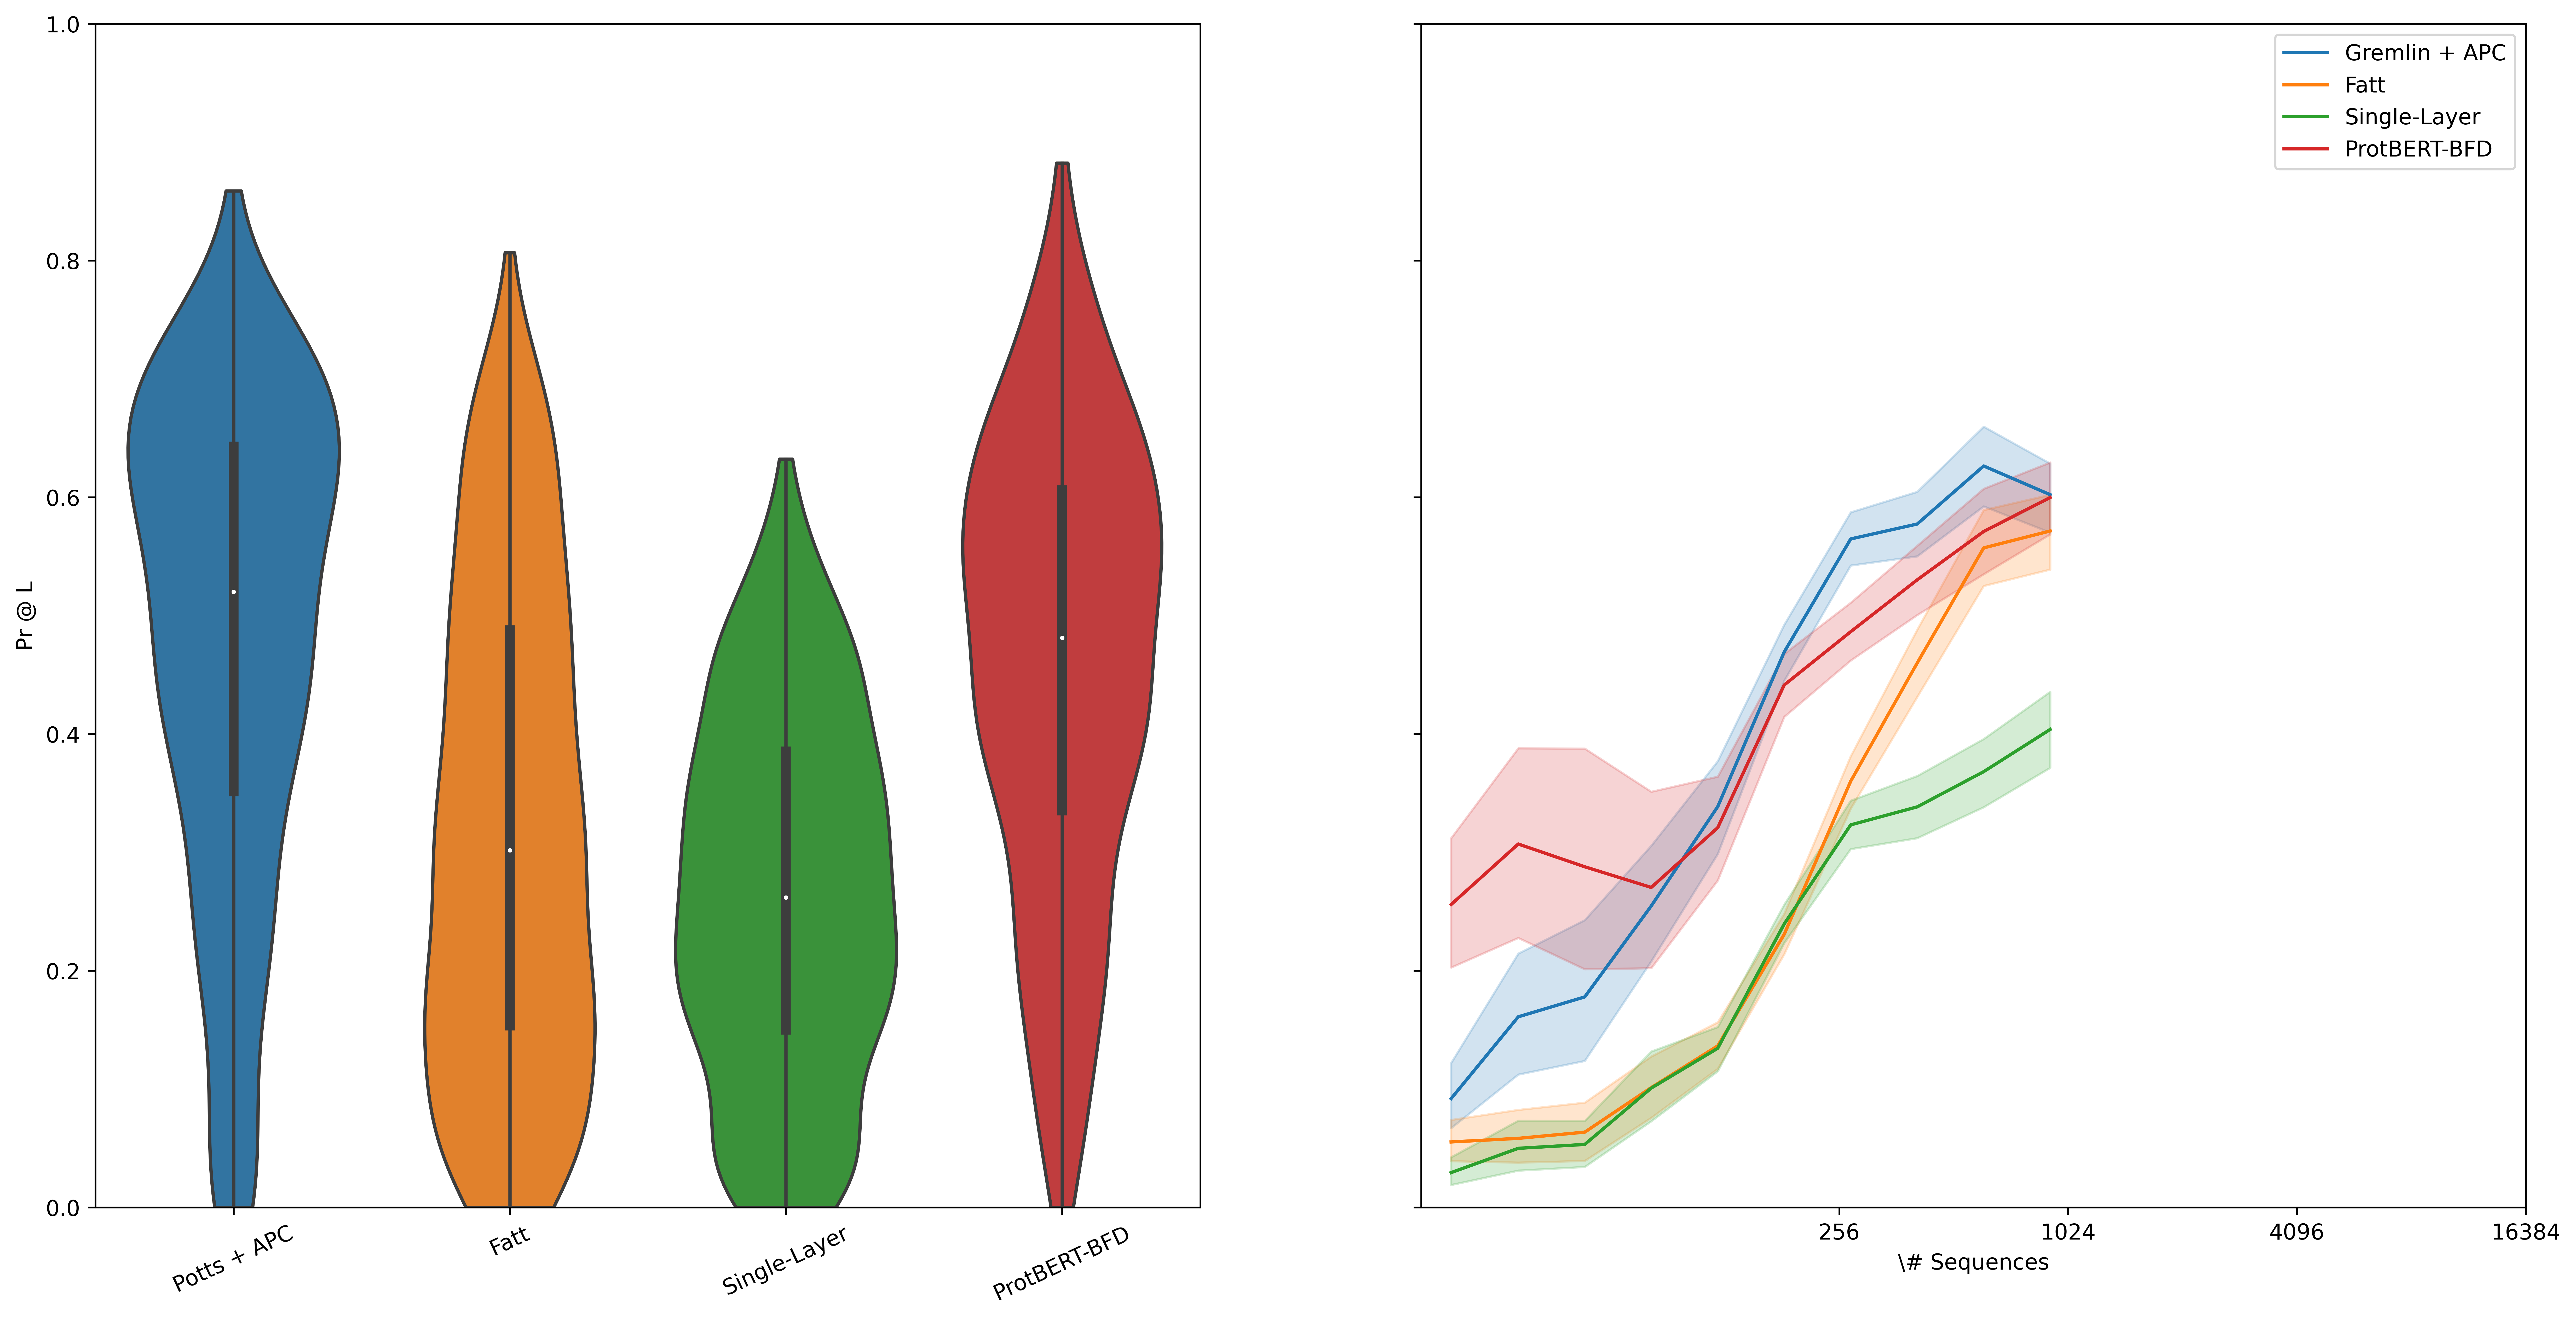

In [10]:
fig, ax = plt.subplots(figsize=(20, 10), dpi=600, ncols=2, sharey=True)
sns.violinplot(x="sweep_name", y="pr_at_L", order=["gremlin-apc", "fatt-refactor", "transformer", "protbert-bfd"], data=df, cut=0, ax=ax[0])
out, bins = pd.cut(df["log_num_seqs"], bins=10, retbins=True, include_lowest=True, labels=False)
sns.lineplot(x=bins[np.array(out, dtype=np.int32)], y="pr_at_L", hue="sweep_name", hue_order=["gremlin-apc", "fatt-refactor", "transformer", "protbert-bfd"], data=df, ax=ax[1])
ax[0].set_xticklabels(["Potts + APC", "Fatt", "Single-Layer", "ProtBERT-BFD"], Rotation=25)
ax[0].set_xlabel("")
ax[0].set_ylabel("Pr @ L")
ax[0].set_ylim(0, 1.0)
ax[1].legend(["Gremlin + APC", "Fatt", "Single-Layer", "ProtBERT-BFD"])
ax[1].set_xlabel("\# Sequences")
ax[1].set_xticks([8, 10, 12, 14])
ax[1].set_xticklabels(2 ** np.array([8, 10, 12, 14]))
# ax[1].set_xticklabels([256, 1024, 4096, 16384])
plt.show()
#fig.savefig("figs/pl_violin_line.pdf", bbox_inches="tight", pad_inches=0.1)

/home/nickbhat/projects/mogwai/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """


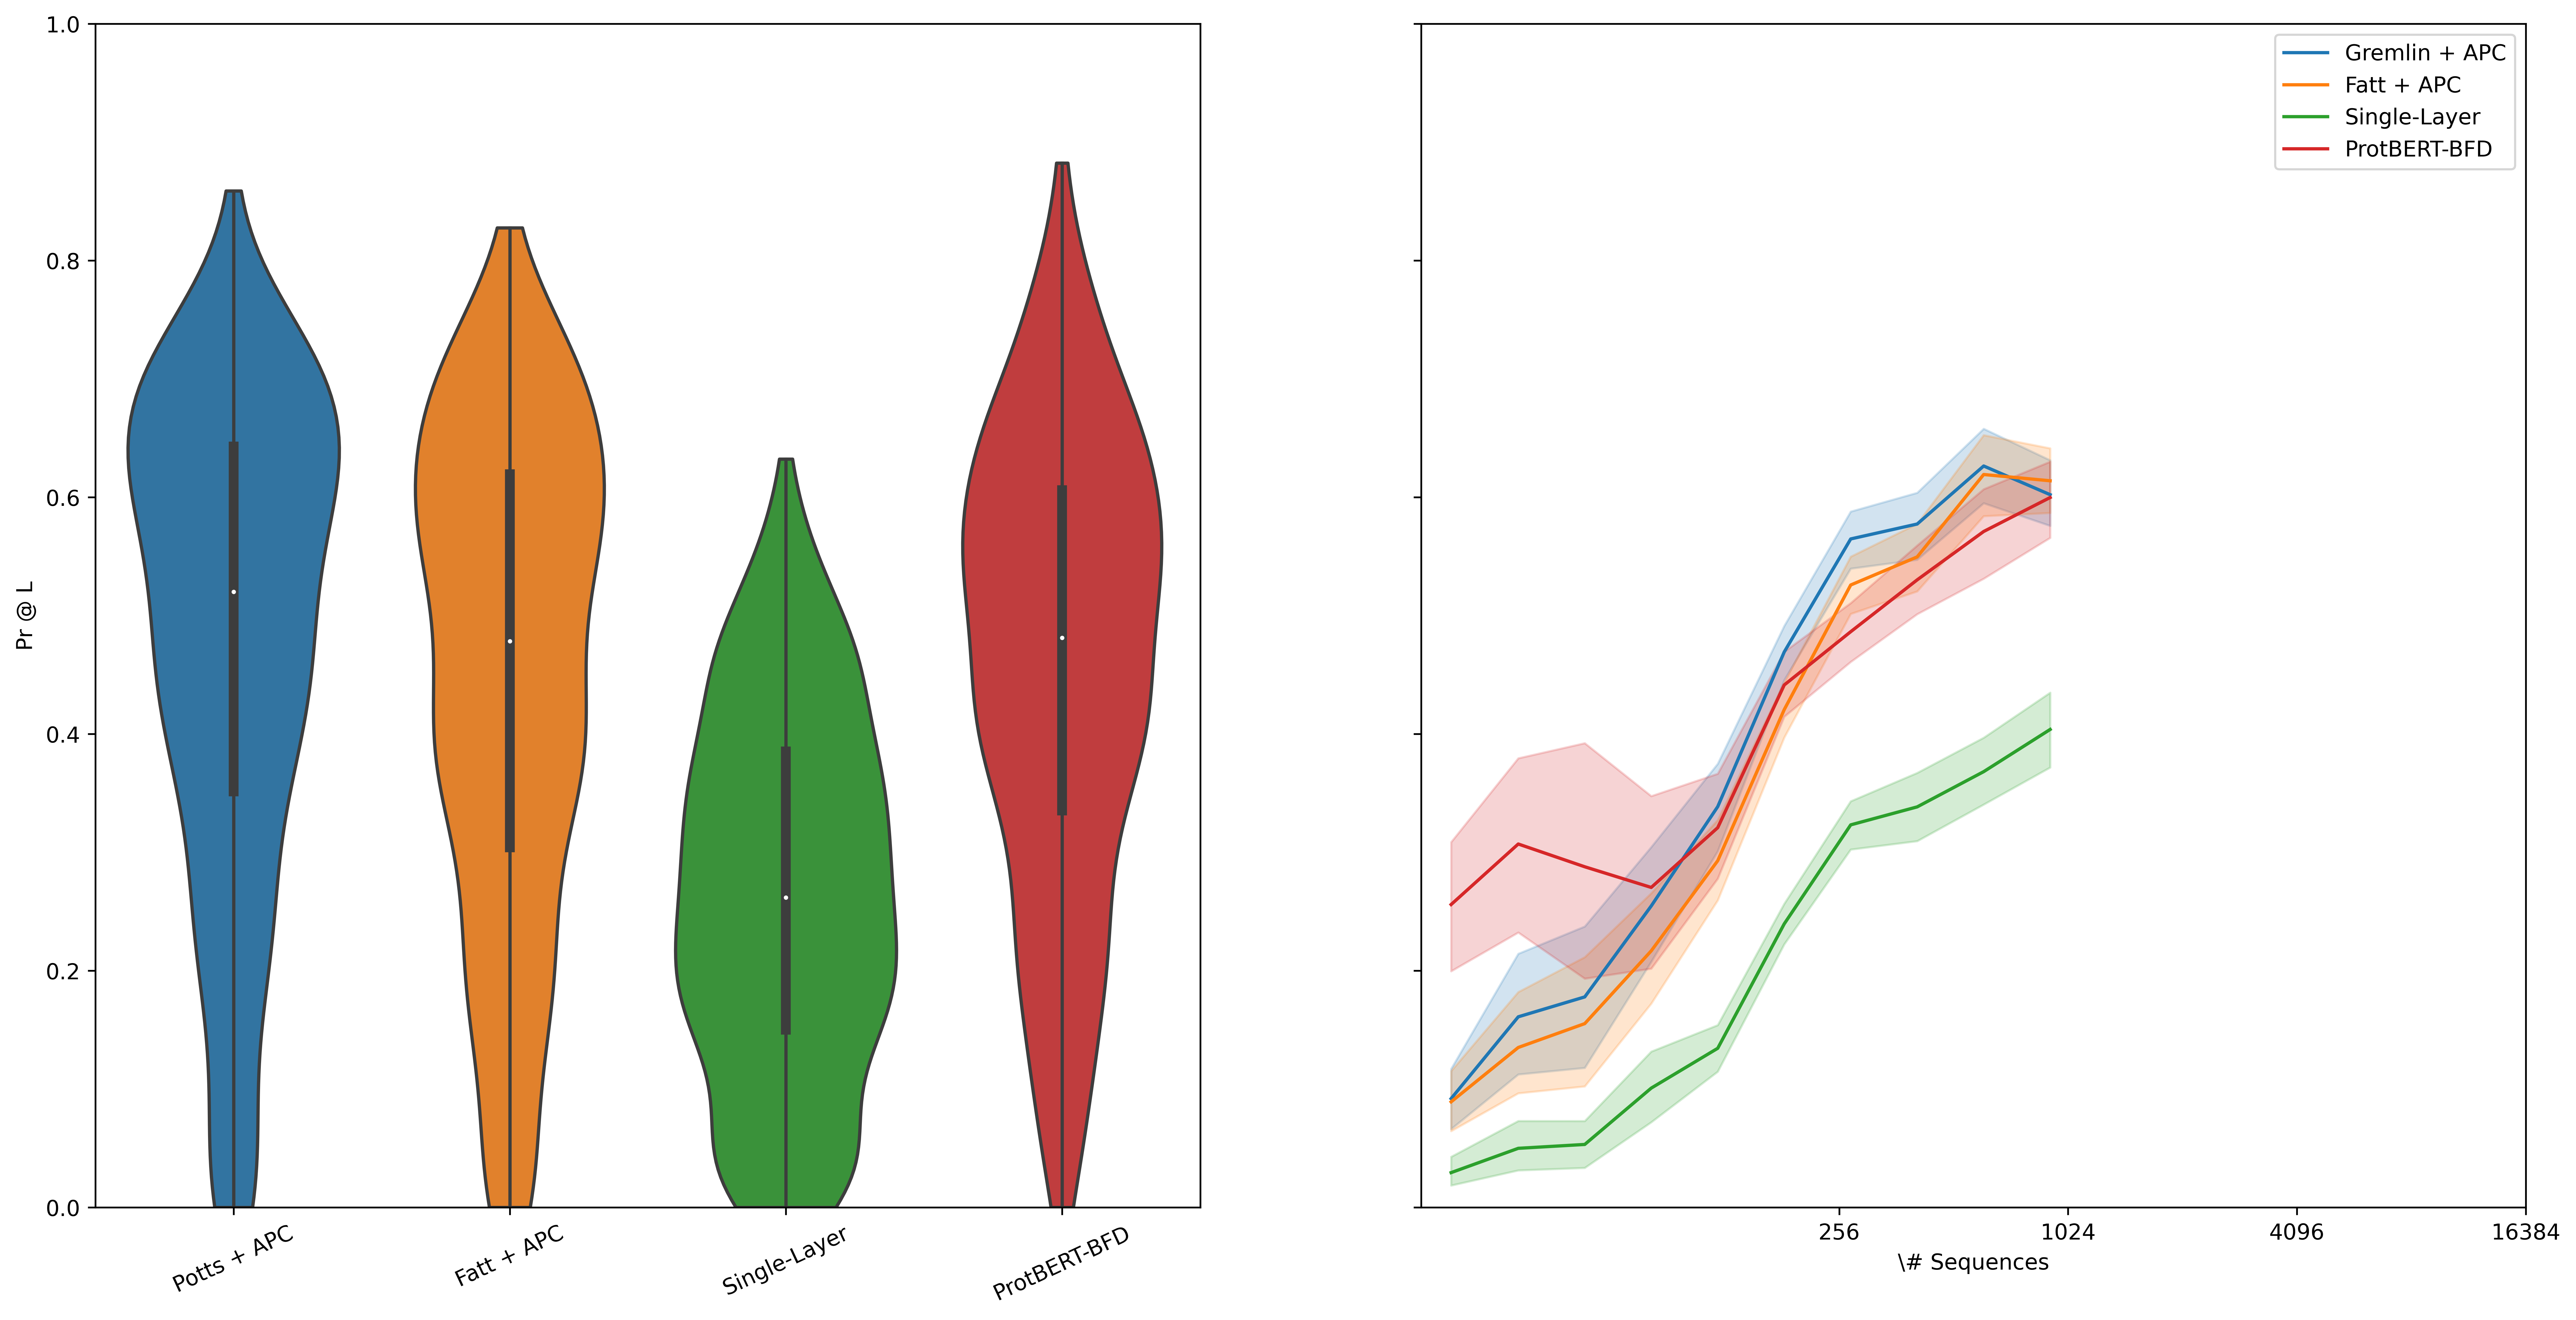

In [11]:
fig, ax = plt.subplots(figsize=(20, 10), dpi=600, ncols=2, sharey=True)
sns.violinplot(x="sweep_name", y="pr_at_L", order=["gremlin-apc", "fatt-refactor-apc", "transformer", "protbert-bfd"], data=df, cut=0, ax=ax[0])
out, bins = pd.cut(df["log_num_seqs"], bins=10, retbins=True, include_lowest=True, labels=False)
sns.lineplot(x=bins[np.array(out, dtype=np.int32)], y="pr_at_L", hue="sweep_name", hue_order=["gremlin-apc", "fatt-refactor-apc", "transformer", "protbert-bfd"], data=df, ax=ax[1])
ax[0].set_xticklabels(["Potts + APC", "Fatt + APC", "Single-Layer", "ProtBERT-BFD"], Rotation=25)
ax[0].set_xlabel("")
ax[0].set_ylabel("Pr @ L")
ax[0].set_ylim(0, 1.0)
ax[1].legend(["Gremlin + APC", "Fatt + APC", "Single-Layer", "ProtBERT-BFD"])
ax[1].set_xlabel("\# Sequences")
ax[1].set_xticks([8, 10, 12, 14])
ax[1].set_xticklabels(2 ** np.array([8, 10, 12, 14]))
# ax[1].set_xticklabels([256, 1024, 4096, 16384])
plt.show()
#fig.savefig("figs/pl_violin_line.pdf", bbox_inches="tight", pad_inches=0.1)

/home/nickbhat/projects/mogwai/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """


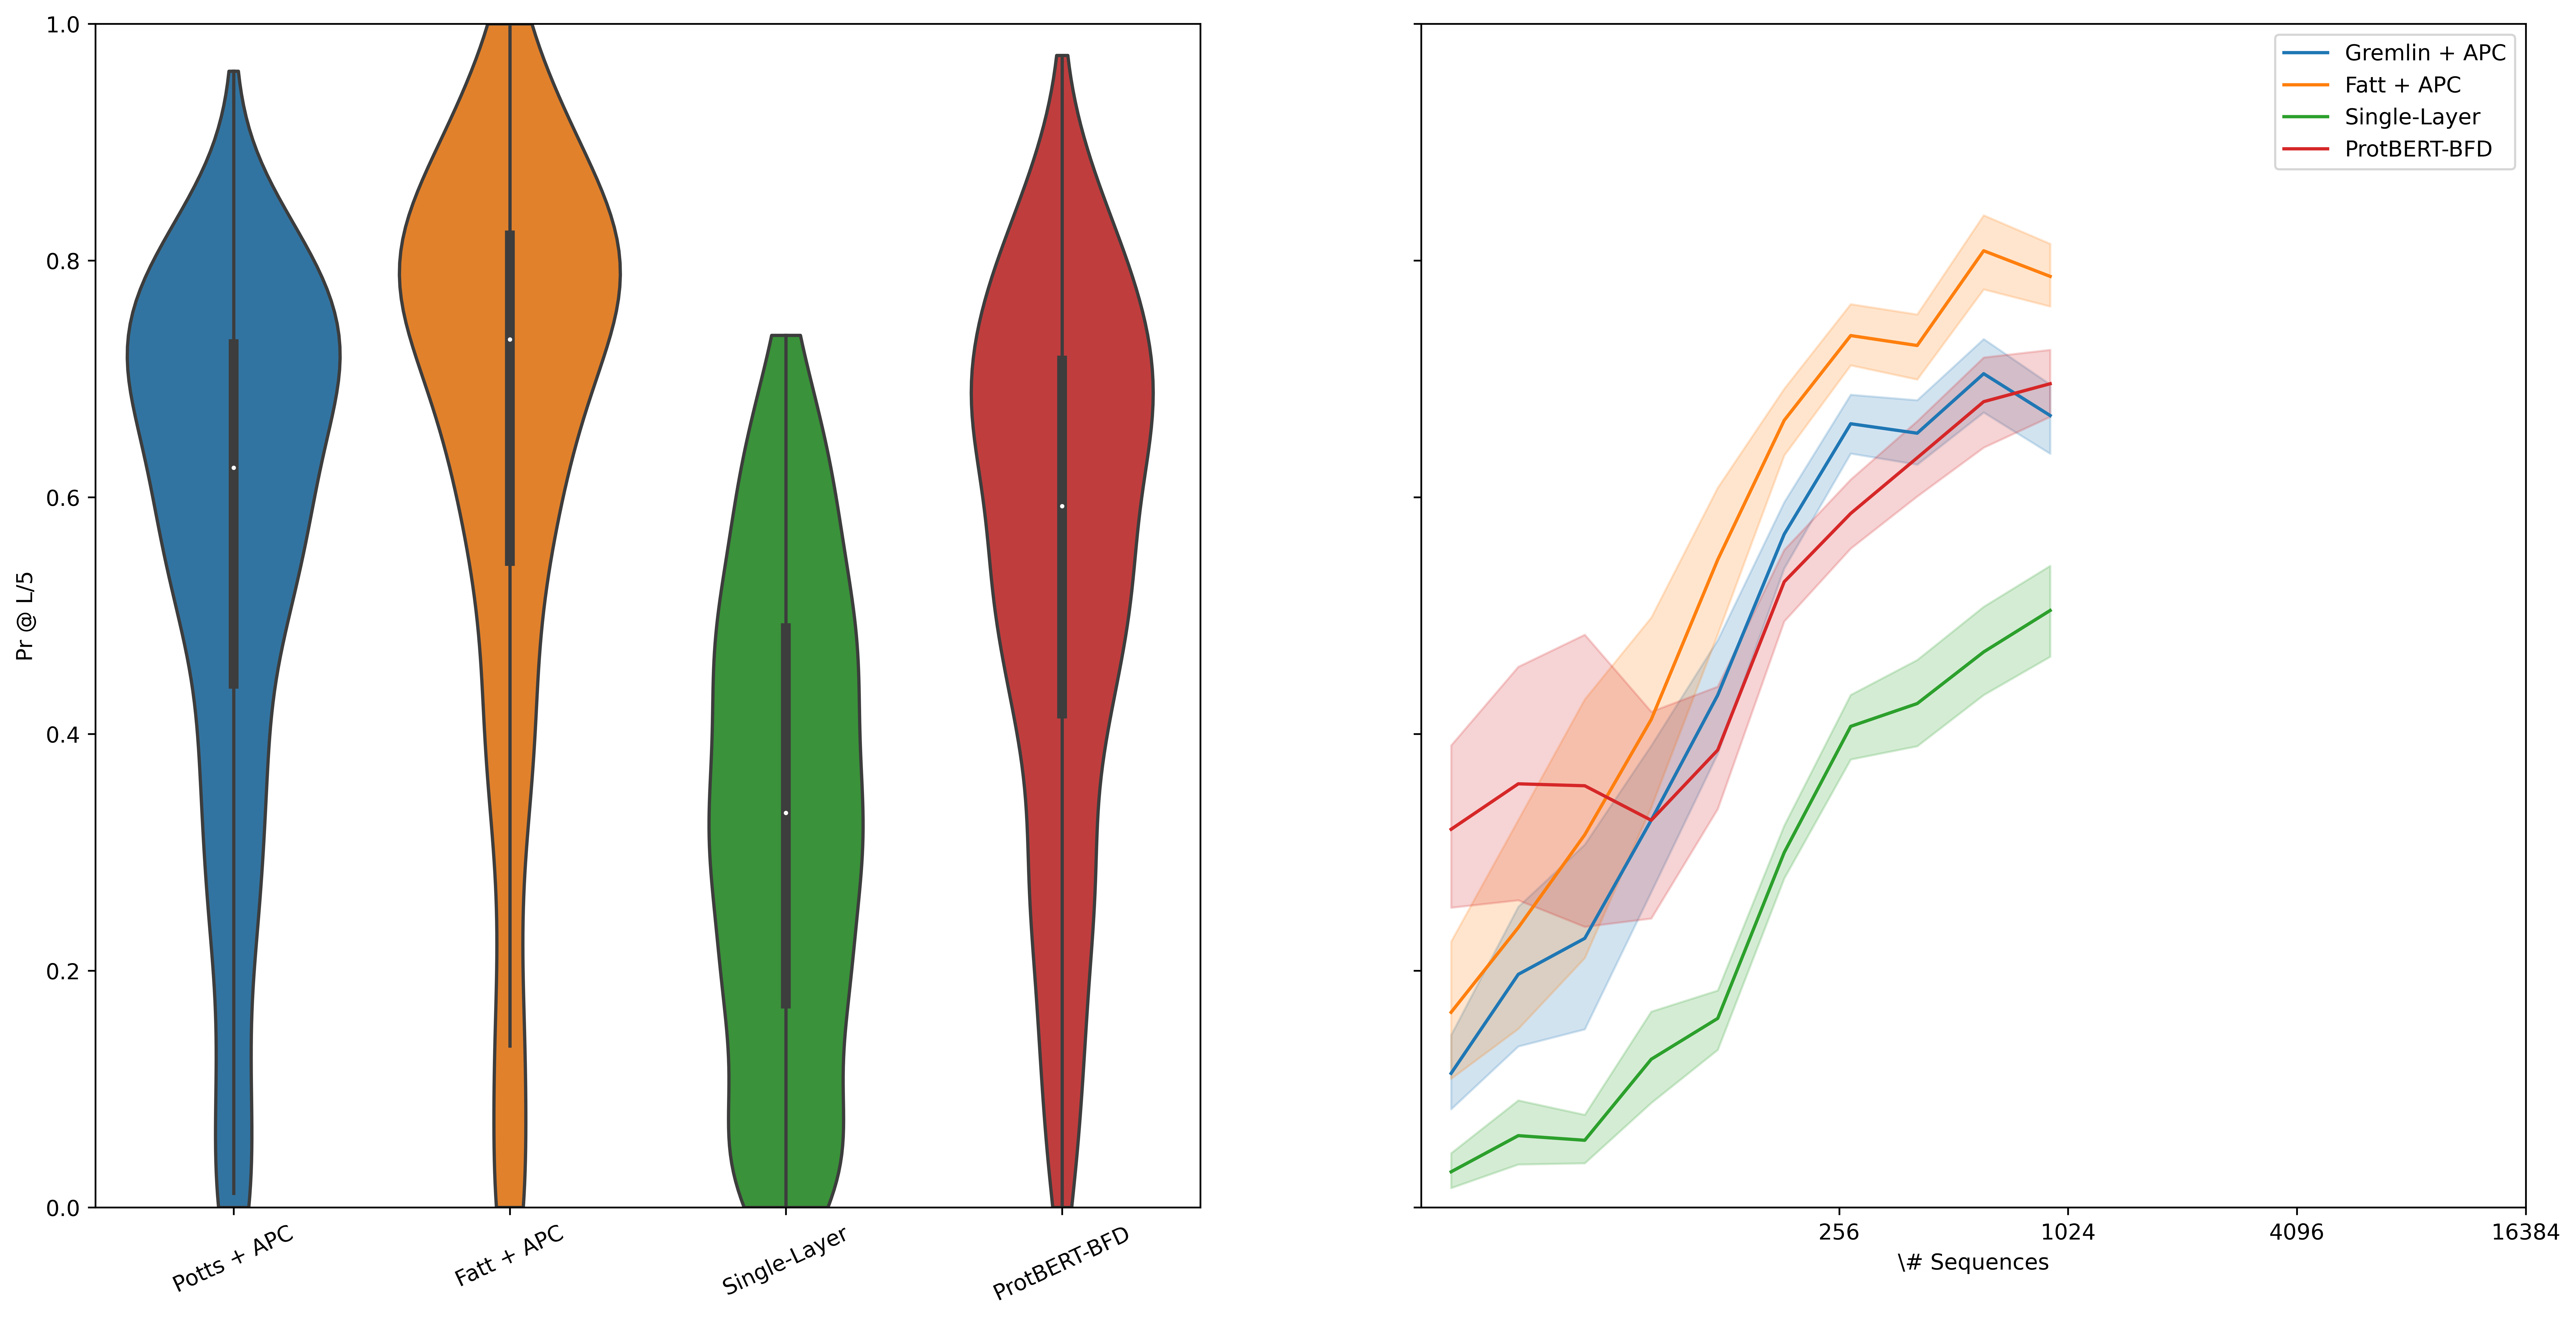

In [12]:
fig, ax = plt.subplots(figsize=(20, 10), dpi=600, ncols=2, sharey=True)
sns.violinplot(x="sweep_name", y="pr_at_L_5", order=["gremlin-apc", "fatt-refactor-apc", "transformer", "protbert-bfd"], data=df, cut=0, ax=ax[0])
out, bins = pd.cut(df["log_num_seqs"], bins=10, retbins=True, include_lowest=True, labels=False)
sns.lineplot(x=bins[np.array(out, dtype=np.int32)], y="pr_at_L_5", hue="sweep_name", hue_order=["gremlin-apc", "fatt-refactor-apc", "transformer", "protbert-bfd"], data=df, ax=ax[1])
ax[0].set_xticklabels(["Potts + APC", "Fatt + APC", "Single-Layer", "ProtBERT-BFD"], Rotation=25)
ax[0].set_xlabel("")
ax[0].set_ylabel("Pr @ L/5")
ax[0].set_ylim(0, 1.0)
ax[1].legend(["Gremlin + APC", "Fatt + APC", "Single-Layer", "ProtBERT-BFD"])
ax[1].set_xlabel("\# Sequences")
ax[1].set_xticks([8, 10, 12, 14])
ax[1].set_xticklabels(2 ** np.array([8, 10, 12, 14]))
# ax[1].set_xticklabels([256, 1024, 4096, 16384])
plt.show()
#fig.savefig("figs/pl_violin_line.pdf", bbox_inches="tight", pad_inches=0.1)

In [13]:
def get_delta(df, k1, k2, m = "auc"):
    filtered_df_x = df[df.sweep_name == k1]
    filtered_df_y = df[df.sweep_name == k2]
    lsuffix = '_x'
    rsuffix = '_y'
    merged_df = pd.merge(filtered_df_x, filtered_df_y, on='pdb_idx', suffixes=(lsuffix, rsuffix))
    
    deltas = merged_df[m + lsuffix] - merged_df[m + rsuffix]
    plt.hist(deltas, bins=20)
    plt.title(f"{k1} - {k2}, mean: {np.mean(deltas):.5f}")

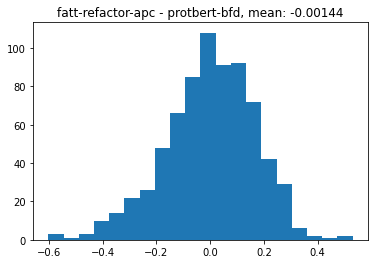

In [14]:
get_delta(df, "fatt-refactor-apc", "protbert-bfd", m="pr_at_L")

In [15]:
def plot_vs(df, k1, k2, m = "auc"):
    filtered_df_x = df[df.sweep_name == k1]
    filtered_df_y = df[df.sweep_name == k2]
    lsuffix = '_x'
    rsuffix = '_y'
    merged_df = pd.merge(filtered_df_x, filtered_df_y, on='pdb_idx', suffixes=(lsuffix, rsuffix))
    print('comparison families: ', len(merged_df))
    lseqs = 'num_seqs' + lsuffix
    rseqs = 'num_seqs' + rsuffix
    if lseqs in merged_df.keys():
        seqs_column = lseqs
    elif rseqs in merged_df.keys():
        seqs_column = rseqs
    else:
        print('no seqs found for ')
        print(df_x['model'].iloc(0))
        print(df_y['model'].iloc(0))
        return
    plt.plot([0, 1], [0, 1], c='k')
    num_seqs = merged_df[seqs_column]
    plt.scatter(merged_df[m + lsuffix], merged_df[m + rsuffix],
                c=num_seqs,
                s=9,
                norm=colors.LogNorm(vmin=num_seqs.min(), vmax=num_seqs.max()),
                cmap='viridis')
    cbar = plt.colorbar()
    # cbar.locator = matplotlib.ticker.LogLocator(base=2)
    # cbar.update_ticks()
    plt.xlabel(k1)
    plt.ylabel(k2)
    cbar.set_label('# of msa sequences')

In [16]:
def plot_pair(df, k1, k2, m):
    plot_vs(df, k1, k2, m)
    #plt.savefig(f"figs/{k2}_vs_{k1}.png", bbox_inches="tight", pad_inches=0.1)
    plt.show()
    plt.close()

comparison families:  747


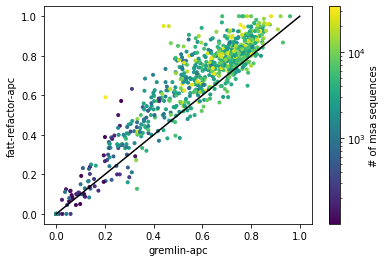

In [17]:
plot_pair(df, "gremlin-apc", "fatt-refactor-apc", "pr_at_L_5")

comparison families:  747


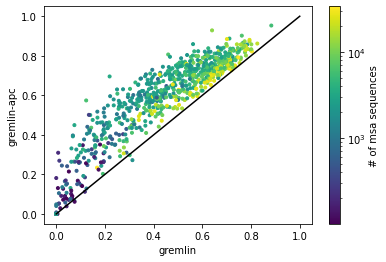

comparison families:  747


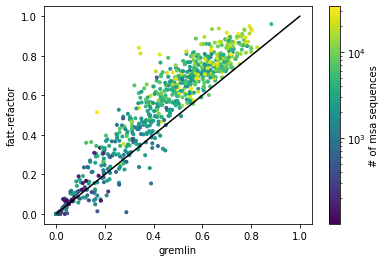

comparison families:  747


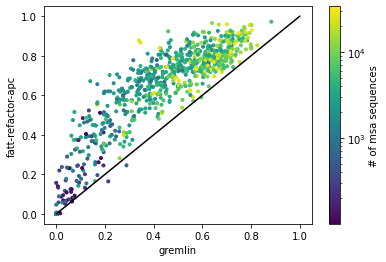

comparison families:  747


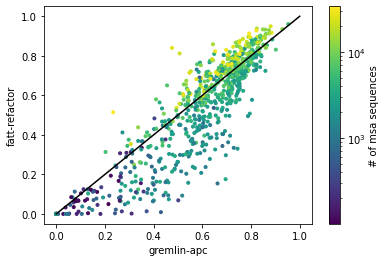

comparison families:  747


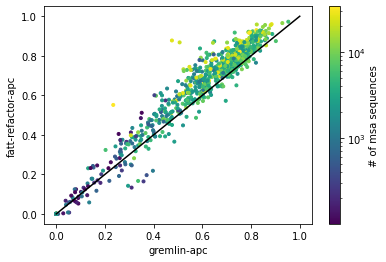

comparison families:  748


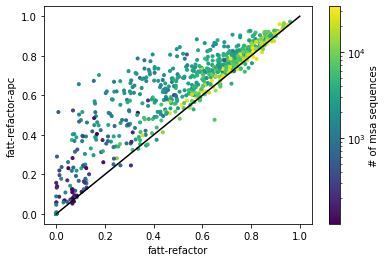

In [18]:
methods = ["gremlin", "gremlin-apc", "fatt-refactor", "fatt-refactor-apc"]
for (k1, k2) in itertools.combinations(methods, 2):
    plot_pair(df, k1, k2, "auc")

comparison families:  747


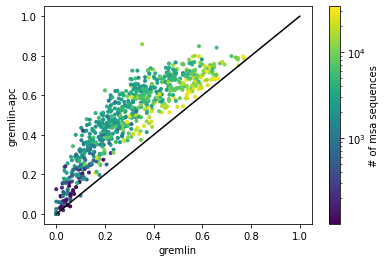

comparison families:  747


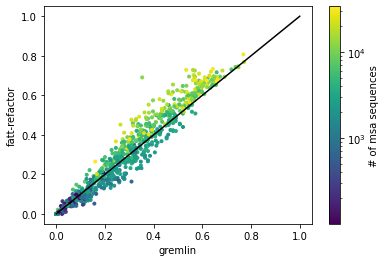

comparison families:  747


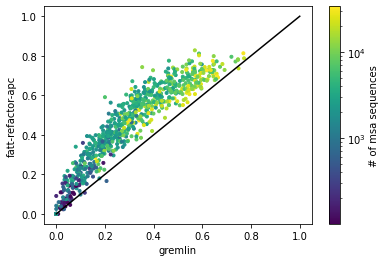

comparison families:  747


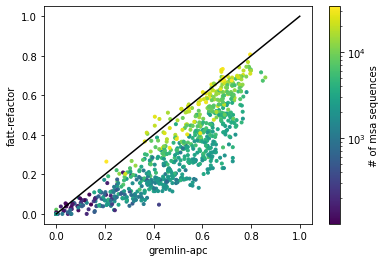

comparison families:  747


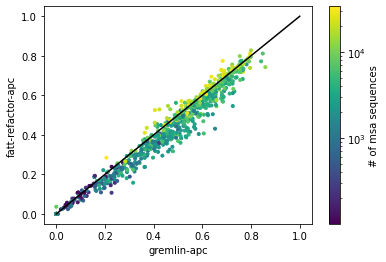

comparison families:  748


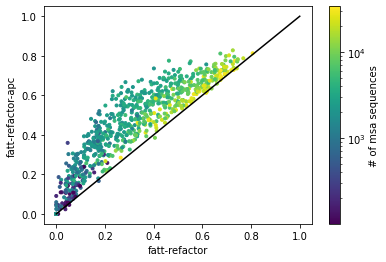

In [19]:
methods = ["gremlin", "gremlin-apc", "fatt-refactor", "fatt-refactor-apc"]
for (k1, k2) in itertools.combinations(methods, 2):
    plot_pair(df, k1, k2, "pr_at_L")

comparison families:  747


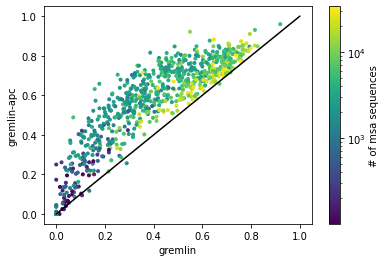

comparison families:  747


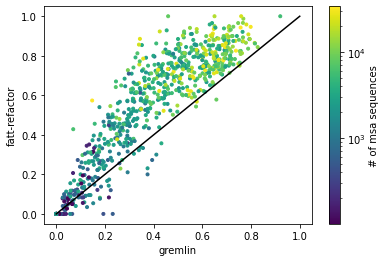

comparison families:  747


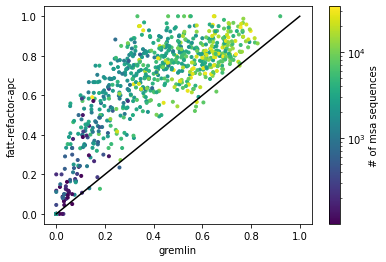

comparison families:  747


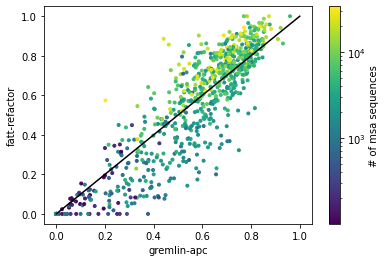

comparison families:  747


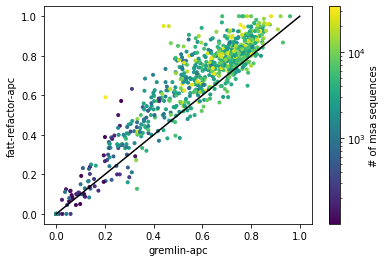

comparison families:  748


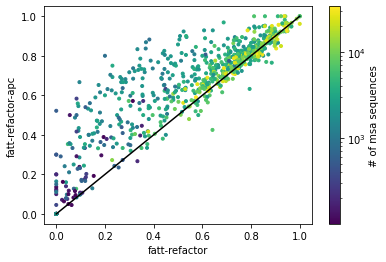

In [20]:
methods = ["gremlin", "gremlin-apc", "fatt-refactor", "fatt-refactor-apc"]
for (k1, k2) in itertools.combinations(methods, 2):
    plot_pair(df, k1, k2, "pr_at_L_5")

comparison families:  723


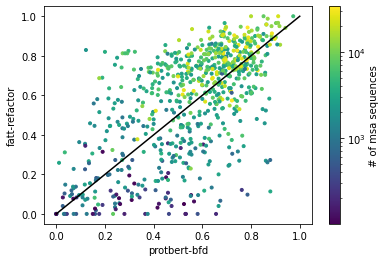

comparison families:  723


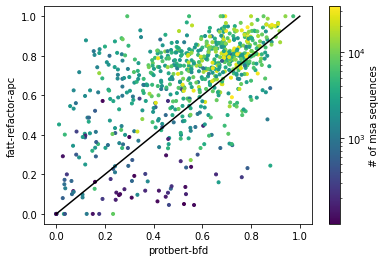

comparison families:  748


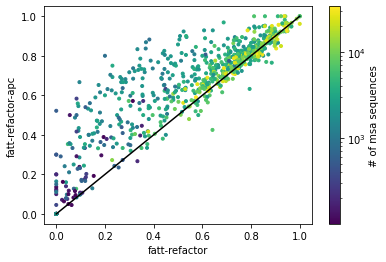

In [21]:
methods = ["protbert-bfd", "fatt-refactor", "fatt-refactor-apc"]
for (k1, k2) in itertools.combinations(methods, 2):
    plot_pair(df, k1, k2, "pr_at_L_5")

comparison families:  705


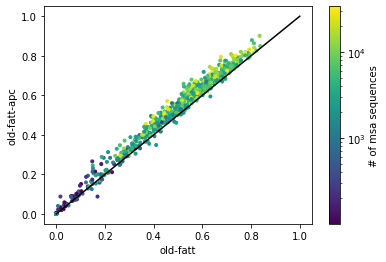

comparison families:  705


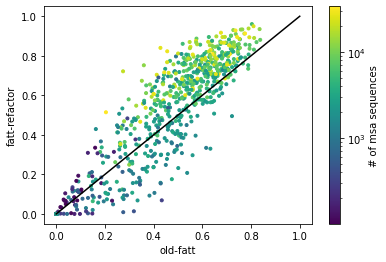

comparison families:  705


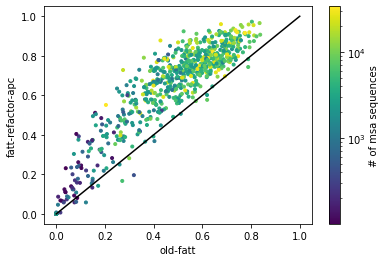

comparison families:  705


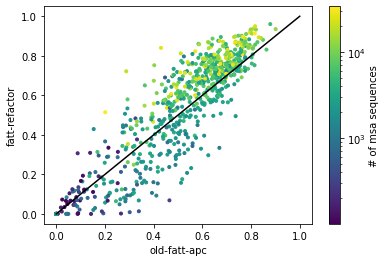

comparison families:  705


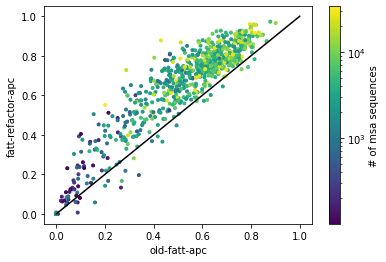

comparison families:  748


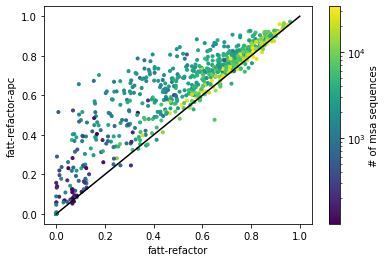

In [22]:
methods = ["old-fatt", "old-fatt-apc", "fatt-refactor", "fatt-refactor-apc"]
for (k1, k2) in itertools.combinations(methods, 2):
    plot_pair(df, k1, k2, "auc")